In [1]:
%run ./Definitions.ipynb
!nvidia-smi
import os

2019-12-25 14:52:00.856367
thunder  Wed Dec 25 14:52:01 2019
[0] GeForce GTX 1080 Ti | 40'C,   0 % |    10 / 11178 MB |
[1] GeForce GTX 1080 Ti | 25'C,   0 % |    10 / 11178 MB |
[2] GeForce GTX 1080 Ti | 26'C,   0 % | 10895 / 11178 MB | patra(10885M)
[3] GeForce GTX 1080 Ti | 25'C,   0 % |    10 / 11178 MB |
[4] GeForce GTX 1080 Ti | 23'C,   0 % |    10 / 11178 MB |
[5] GeForce GTX 1080 Ti | 27'C,   0 % |    10 / 11178 MB |
[6] GeForce GTX 1080 Ti | 30'C,   0 % |    10 / 11178 MB |
[7] GeForce GTX 1080 Ti | 28'C,   0 % | 10936 / 11178 MB | hemelinr(10926M)


/ds/environments/python2020/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
Using TensorFlow backend.
/ds/environments/python2020/lib/python3.7/site-packages/keras/callbacks/callbacks.py:19: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable


Dataset consist of 85730 patients data with 6251 features for each patient
Function definitions executed
Definitions DONE !!

Wed Dec 25 14:52:13 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.87.01    Driver Version: 418.87.01    CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  Off  | 00000000:04:00.0 Off |                  N/A |
| 29%   40C    P0    59W / 250W |     10MiB / 11178MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 108...  Off  | 00000000:06:00.0 Off |                  N/A |
| 29%   25C    P8     7W / 250W |     10Mi

In [2]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # so the IDs match nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"] = "0"   # choose here your GPU (0-7)

import tensorflow as tf
import tensorflow.compat.v1 as tf
import keras
import tensorflow.python.keras.backend as K


In [3]:
img_size = 250
red_size = 224

srcpath = '/ds2/data/retina/UK_BB/UK_BB_DATA/fundus/'
funduspath_CR = DATA_dir + 'Fundus_images_250_CR/'
trainpath = funduspath_CR + 'train/'
valpath = funduspath_CR + 'val/'
testpath = funduspath_CR + 'test/'

### LOAD valid train test and validation image names 

In [4]:
valid_traindf_names = pd.read_pickle(funduspath_CR + 'valid_traindf_names.pkl')
valid_valdf_names = pd.read_pickle(funduspath_CR + 'valid_valdf_names.pkl')
valid_testdf_names = pd.read_pickle(funduspath_CR + 'valid_testdf_names.pkl')

valid_traindf_names.shape , valid_valdf_names.shape , valid_testdf_names.shape

((101834, 5), (33943, 5), (33936, 5))

In [5]:
img_size = 250
red_size = 224

srcpath = '/ds2/data/retina/UK_BB/UK_BB_DATA/fundus/'
funduspath_CR = DATA_dir + 'Fundus_images_250_CR/'
trainpath = funduspath_CR + 'train/'
valpath = funduspath_CR + 'val/'
testpath = funduspath_CR + 'test/'

## Handling Imbalanced Data sets

In [6]:
which_gt = 4 # CHANGE 1,2,3,4 implies 'GT523', 'GT19', 'GTi', 'GTu'
n_NG = 0 # non glaucoma
n_G = 0  # glaucoma

GT_dict = {1:'GT523',2:'GT19',3:'GTi',4:'GTu'}
Class = GT_dict[which_gt]
temp = valid_traindf_names[Class]
for i in range(len(temp)):
    if(temp[i] == '1'):
        n_G += 1
    else:
        n_NG += 1
        
print("No. of Glaucoma patients in training set:",n_G)
print("No. of non-Glaucoma patients in training set:",n_NG)

No. of Glaucoma patients in training set: 2379
No. of non-Glaucoma patients in training set: 99455


### 1. Over Sampling Train set

In [7]:
# Oversample the minority class

X_train = valid_traindf_names['Fundus_Filenames']
y_train = valid_traindf_names[GT_dict[which_gt]]

# Converting class values to int 1 or 0
y_train = y_train.astype(int)

# concatenate our training data back together
X = pd.concat([X_train, y_train], axis=1)

# separate minority and majority classes
not_glaucoma = X[X[Class]==0]
glaucoma = X[X[Class]==1]

# upsample minority
glaucoma_upsampled = resample(glaucoma,
                              replace=True, # sample with replacement
                              n_samples=len(not_glaucoma), # match number in majority class
                              random_state=42) # reproducible results

# combine majority and upsampled minority
upsampled = pd.concat([not_glaucoma,glaucoma_upsampled])

# shuffle upsampled dataframe for training
upsampled = upsampled.sample(frac=1)


In [8]:
X[Class].value_counts()

0    99455
1     2379
Name: GTu, dtype: int64

In [9]:
upsampled[Class].value_counts()

1    99455
0    99455
Name: GTu, dtype: int64

#### validation distribution

In [10]:
valid_valdf_names[Class].value_counts()

0    33134
1      809
Name: GTu, dtype: int64

### Oversampling minority with less imbalance - in train set
Original imbalance ratio **X-** 1:40

Imbalance ratio **up1**-1:5, **up2**-1:10, **up3**-1:20, **up4**-1:30

Balanced ratio **upsampled**-1:1

In [11]:
# upsampling minority
glaucoma_up1 = resample(glaucoma, replace=True, # sample with replacement 
                        n_samples=floor(len(not_glaucoma)/5), # match number in majority class
                        random_state=42) # reproducible results

glaucoma_up2 = resample(glaucoma, replace=True, # sample with replacement 
                        n_samples=floor(len(not_glaucoma)/10), # match number in majority class
                        random_state=42) # reproducible results

glaucoma_up3 = resample(glaucoma, replace=True, # sample with replacement 
                        n_samples=floor(len(not_glaucoma)/20), # match number in majority class
                        random_state=42) # reproducible results

glaucoma_up4 = resample(glaucoma, replace=True, # sample with replacement 
                        n_samples=floor(len(not_glaucoma)/30), # match number in majority class
                        random_state=42) # reproducible results

# combine majority and upsampled minority
up1 = pd.concat([not_glaucoma,glaucoma_up1])
up2 = pd.concat([not_glaucoma,glaucoma_up2])
up3 = pd.concat([not_glaucoma,glaucoma_up3])
up4 = pd.concat([not_glaucoma,glaucoma_up4])

# shuffle upsampled dataframe for training
up1 = up1.sample(frac=1)
up2 = up2.sample(frac=1)
up3 = up3.sample(frac=1)
up4 = up4.sample(frac=1)


In [12]:
print("up1")
print(up1[Class].value_counts())
print("up2")
print(up2[Class].value_counts())
print("up1")
print(up3[Class].value_counts())
print("up4")
print(up4[Class].value_counts())

up1
0    99455
1    19891
Name: GTu, dtype: int64
up2
0    99455
1     9945
Name: GTu, dtype: int64
up1
0    99455
1     4972
Name: GTu, dtype: int64
up4
0    99455
1     3315
Name: GTu, dtype: int64


### 2. Class weight

In [13]:
# Setting class weight for retraining:

# compute_class_weight('balanced', np.unique(y_train), y_train)
# class_weight = [0.5, 2] # experiment with different values
# n_NG , n_G

## Define Model and Metrics

In [14]:
reg_value=0.001
METRICS = [keras.metrics.BinaryAccuracy(name='Accuracy'),
           Precision, 
           Recall, 
           F1,
           keras.metrics.AUC(name='AUC')]

def mobilenet_model():       
    mobile_conv = MobileNet(weights='imagenet', include_top=False, input_shape=(red_size, red_size, 3))

    # UnFreeze last conv layer
    for layer in mobile_conv.layers[:78]:
        layer.trainable = False
    for layer in mobile_conv.layers[78:]:
        layer.trainable = True
        
    # Create the model
    model = models.Sequential()
    model.add(mobile_conv)
 
    # Add new layers
    # https://adventuresinmachinelearning.com/global-average-pooling-convolutional-neural-networks/
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dense(1, activation='sigmoid'))
 
    return model

### Augmentation
https://nbviewer.jupyter.org/github/aleju/imgaug-doc/blob/master/notebooks/A01%20-%20Load%20and%20Augment%20an%20Image.ipynb

In [15]:
seq = iaa.Sequential([
    iaa.Fliplr(0.5),
    iaa.Affine(scale=1.1),
    iaa.Affine(rotate=(-10, 10)),
    # iaa.GammaContrast(0.9),
    iaa.Resize({"height": 230, "width": 230}),
    iaa.CropToFixedSize(width=red_size, height=red_size)
    ])

### Flow from Dataframe
https://www.kaggle.com/dmitrypukhov/cnn-with-imagedatagenerator-flow-from-dataframe

In [16]:
valid_traindf_names[Class] = valid_traindf_names[Class].astype(int)
valid_valdf_names[Class] = valid_valdf_names[Class].astype(int)

In [17]:
# To use same settings as mobilenet
# from keras.applications.mobilenet import preprocess_input
# train_datagen=ImageDataGenerator(preprocessing_function=preprocess_input)

train_datagen = ImageDataGenerator(preprocessing_function=seq.augment_image, samplewise_center=True, 
                                   featurewise_center=True, featurewise_std_normalization=True,
                                   rescale= 1./255) 
val_datagen = ImageDataGenerator(samplewise_center=True, 
                                featurewise_center=True, featurewise_std_normalization=True,
                                rescale= 1./255)  
BATCH_SIZE = 32

print("\nOriginal imbalanced train data: ")
imb_train_generator = train_datagen.flow_from_dataframe(
    # dataframe=valid_traindf_names,
    dataframe = valid_traindf_names, # imbalanced train dataframe
    directory=trainpath,
    x_col=valid_traindf_names.columns[0],
    y_col=valid_traindf_names.columns[which_gt],
#     x_col = upsampled.columns[0], # upsampled data
#     y_col = upsampled.columns[1], # upsampled data
    class_mode="raw",
    shuffle=False,
    target_size=(red_size, red_size),
    batch_size=BATCH_SIZE
)

print("\nOriginal validation data: ")
validation_generator = val_datagen.flow_from_dataframe(
    dataframe=valid_valdf_names,
    directory=valpath,
    x_col=valid_valdf_names.columns[0],
    y_col=valid_valdf_names.columns[which_gt],
    class_mode="raw",
    shuffle=False,
    target_size=(red_size, red_size),
    batch_size=BATCH_SIZE
)

print("\nUpsampled train data 1:1 ")
up_train_generator = train_datagen.flow_from_dataframe(
    # dataframe=valid_traindf_names,
    dataframe = upsampled, # upsampled data
    directory=trainpath,
    # x_col=valid_traindf_names.columns[0],
    # y_col=valid_traindf_names.columns[which_gt],
    x_col = upsampled.columns[0], # upsampled data
    y_col = upsampled.columns[1], # upsampled data
    class_mode="raw",
    shuffle=False,
    target_size=(red_size, red_size),
    batch_size=BATCH_SIZE
)

print("\nUP1 train data 1:5 ")
up1_train_generator = train_datagen.flow_from_dataframe(
    # dataframe=valid_traindf_names,
    dataframe = up1, # upsampled data
    directory=trainpath,
    # x_col=valid_traindf_names.columns[0],
    # y_col=valid_traindf_names.columns[which_gt],
    x_col = up1.columns[0], # upsampled data
    y_col = up1.columns[1], # upsampled data
    class_mode="raw",
    shuffle=False,
    target_size=(red_size, red_size),
    batch_size=BATCH_SIZE
)

print("\nUP2 train data 1:10 ")
up2_train_generator = train_datagen.flow_from_dataframe(
    # dataframe=valid_traindf_names,
    dataframe = up2, # upsampled data
    directory=trainpath,
    # x_col=valid_traindf_names.columns[0],
    # y_col=valid_traindf_names.columns[which_gt],
    x_col = up2.columns[0], # upsampled data
    y_col = up2.columns[1], # upsampled data
    class_mode="raw",
    shuffle=False,
    target_size=(red_size, red_size),
    batch_size=BATCH_SIZE
)

print("\nUP3 train data 1:20 ")
up3_train_generator = train_datagen.flow_from_dataframe(
    # dataframe=valid_traindf_names,
    dataframe = up3, # upsampled data
    directory=trainpath,
    # x_col=valid_traindf_names.columns[0],
    # y_col=valid_traindf_names.columns[which_gt],
    x_col = up3.columns[0], # upsampled data
    y_col = up3.columns[1], # upsampled data
    class_mode="raw",
    shuffle=False,
    target_size=(red_size, red_size),
    batch_size=BATCH_SIZE
)

print("\nUP4 train data 1:30 ")
up4_train_generator = train_datagen.flow_from_dataframe(
    # dataframe=valid_traindf_names,
    dataframe = up4, # upsampled data
    directory=trainpath,
    # x_col=valid_traindf_names.columns[0],
    # y_col=valid_traindf_names.columns[which_gt],
    x_col = up4.columns[0], # upsampled data
    y_col = up4.columns[1], # upsampled data
    class_mode="raw",
    shuffle=False,
    target_size=(red_size, red_size),
    batch_size=BATCH_SIZE
)



Original imbalanced train data: 
Found 101834 validated image filenames.

Original validation data: 
Found 33943 validated image filenames.

Upsampled train data 1:1 
Found 198910 validated image filenames.

UP1 train data 1:5 
Found 119346 validated image filenames.

UP2 train data 1:10 
Found 109400 validated image filenames.

UP3 train data 1:20 
Found 104427 validated image filenames.

UP4 train data 1:30 
Found 102770 validated image filenames.


### Choosing parameters and model compile

In [18]:
which_model = mobilenet_model
# which_model = vgg_model
# which_model = resnet50_model

model = which_model()
learning_rate  = 0.0001 
decay = 1e-5
momentum=0.9
opt = Adam(lr=learning_rate, decay = decay) 
model.compile(loss='binary_crossentropy', metrics=METRICS, optimizer=opt)
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Model)   (None, 7, 7, 1024)        3228864   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1025      
Total params: 3,229,889
Trainable params: 1,589,249
Non-trainable params: 1,640,640
_________________________________________________________________


In [19]:
reduce_lr = ReduceLROnPlateau(monitor='val_F1', factor=0.1, patience=10, min_lr=0.000001, verbose=1)
n_epochs=200
n_steps_per_epoch = 50
n_validation_steps = 10

### Train with upsampled data (1:1)

In [20]:
start = time.time()
up_history = model.fit_generator(up_train_generator, 
                              epochs=n_epochs, 
                              steps_per_epoch=n_steps_per_epoch,
                              validation_data=validation_generator,
                              validation_steps=n_validation_steps, 
                              callbacks=[reduce_lr]
                             )
end = time.time()

/ds/environments/python2020/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:339: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  if not isinstance(values, collections.Sequence):


Epoch 1/200


/ds/environments/python2020/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/ds/environments/python2020/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


50/50 [==============================] - 23s 457ms/step - loss: 0.6989 - Accuracy: 0.5763 - Precision: 0.5650 - Recall: 0.5935 - F1: 0.5669 - AUC: 0.6173 - val_loss: 1.7864 - val_Accuracy: 0.0375 - val_Precision: 0.0345 - val_Recall: 0.7000 - val_F1: 0.0651 - val_AUC: 0.5668
Epoch 2/200
50/50 [==============================] - 22s 433ms/step - loss: 0.6538 - Accuracy: 0.6338 - Precision: 0.6381 - Recall: 0.6404 - F1: 0.6342 - AUC: 0.6796 - val_loss: 0.9340 - val_Accuracy: 0.2656 - val_Precision: 0.0042 - val_Recall: 0.1000 - val_F1: 0.0080 - val_AUC: 0.8809
Epoch 3/200
50/50 [==============================] - 23s 458ms/step - loss: 0.6346 - Accuracy: 0.6456 - Precision: 0.6334 - Recall: 0.6857 - F1: 0.6537 - AUC: 0.7035 - val_loss: 0.9404 - val_Accuracy: 0.3469 - val_Precision: 0.0318 - val_Recall: 0.5000 - val_F1: 0.0591 - val_AUC: 0.6260
Epoch 4/200
50/50 [==============================] - 23s 464ms/step - loss: 0.6381 - Accuracy: 0.6338 - Precision: 0.6317 - Recall: 0.5972 - F1: 0.6

Epoch 29/200
50/50 [==============================] - 23s 468ms/step - loss: 0.5656 - Accuracy: 0.7119 - Precision: 0.7111 - Recall: 0.7444 - F1: 0.7209 - AUC: 0.7771 - val_loss: 1.0209 - val_Accuracy: 0.1125 - val_Precision: 0.0175 - val_Recall: 0.4000 - val_F1: 0.0334 - val_AUC: 0.4302
Epoch 30/200
50/50 [==============================] - 23s 466ms/step - loss: 0.5706 - Accuracy: 0.7000 - Precision: 0.6896 - Recall: 0.7240 - F1: 0.7015 - AUC: 0.7711 - val_loss: 1.1208 - val_Accuracy: 0.1781 - val_Precision: 0.0198 - val_Recall: 0.3500 - val_F1: 0.0372 - val_AUC: 0.6913
Epoch 31/200
50/50 [==============================] - 23s 467ms/step - loss: 0.5765 - Accuracy: 0.7025 - Precision: 0.6953 - Recall: 0.7345 - F1: 0.7034 - AUC: 0.7683 - val_loss: 1.1366 - val_Accuracy: 0.1312 - val_Precision: 0.0214 - val_Recall: 0.6000 - val_F1: 0.0414 - val_AUC: 0.7051
Epoch 32/200
50/50 [==============================] - 23s 469ms/step - loss: 0.5702 - Accuracy: 0.7006 - Precision: 0.7044 - Recall: 

50/50 [==============================] - 23s 468ms/step - loss: 0.5595 - Accuracy: 0.7056 - Precision: 0.6918 - Recall: 0.7472 - F1: 0.7122 - AUC: 0.7853 - val_loss: 0.8712 - val_Accuracy: 0.2500 - val_Precision: 0.0166 - val_Recall: 0.3000 - val_F1: 0.0313 - val_AUC: 0.8081
Epoch 58/200
50/50 [==============================] - 23s 461ms/step - loss: 0.5685 - Accuracy: 0.7106 - Precision: 0.6749 - Recall: 0.7596 - F1: 0.7046 - AUC: 0.7766 - val_loss: 0.9877 - val_Accuracy: 0.2344 - val_Precision: 0.0319 - val_Recall: 0.5000 - val_F1: 0.0597 - val_AUC: 0.5311
Epoch 59/200
50/50 [==============================] - 23s 461ms/step - loss: 0.5715 - Accuracy: 0.7038 - Precision: 0.6717 - Recall: 0.7340 - F1: 0.6975 - AUC: 0.7714 - val_loss: 0.9218 - val_Accuracy: 0.2188 - val_Precision: 0.0192 - val_Recall: 0.4000 - val_F1: 0.0365 - val_AUC: 0.5755
Epoch 60/200
50/50 [==============================] - 23s 464ms/step - loss: 0.5653 - Accuracy: 0.7163 - Precision: 0.7307 - Recall: 0.7260 - F1: 

50/50 [==============================] - 23s 460ms/step - loss: 0.5554 - Accuracy: 0.7181 - Precision: 0.7096 - Recall: 0.7569 - F1: 0.7237 - AUC: 0.7897 - val_loss: 1.0622 - val_Accuracy: 0.2406 - val_Precision: 0.0349 - val_Recall: 0.4000 - val_F1: 0.0633 - val_AUC: 0.5850
Epoch 86/200
50/50 [==============================] - 23s 468ms/step - loss: 0.5582 - Accuracy: 0.7050 - Precision: 0.7023 - Recall: 0.7354 - F1: 0.7119 - AUC: 0.7862 - val_loss: 0.9671 - val_Accuracy: 0.2281 - val_Precision: 0.0164 - val_Recall: 0.2667 - val_F1: 0.0302 - val_AUC: 0.3785
Epoch 87/200
50/50 [==============================] - 23s 462ms/step - loss: 0.5403 - Accuracy: 0.7350 - Precision: 0.7094 - Recall: 0.7721 - F1: 0.7337 - AUC: 0.8065 - val_loss: 1.1167 - val_Accuracy: 0.2313 - val_Precision: 0.0460 - val_Recall: 0.7500 - val_F1: 0.0858 - val_AUC: 0.6346
Epoch 88/200
50/50 [==============================] - 23s 464ms/step - loss: 0.5757 - Accuracy: 0.6906 - Precision: 0.6906 - Recall: 0.7110 - F1: 

50/50 [==============================] - 24s 470ms/step - loss: 0.5538 - Accuracy: 0.7175 - Precision: 0.7363 - Recall: 0.7319 - F1: 0.7248 - AUC: 0.7898 - val_loss: 1.2968 - val_Accuracy: 0.1344 - val_Precision: 0.0240 - val_Recall: 0.6000 - val_F1: 0.0460 - val_AUC: 0.5858
Epoch 114/200
50/50 [==============================] - 24s 471ms/step - loss: 0.5542 - Accuracy: 0.7281 - Precision: 0.7147 - Recall: 0.7541 - F1: 0.7288 - AUC: 0.7920 - val_loss: 1.2750 - val_Accuracy: 0.1469 - val_Precision: 0.0073 - val_Recall: 0.2000 - val_F1: 0.0141 - val_AUC: 0.7162
Epoch 115/200
50/50 [==============================] - 23s 462ms/step - loss: 0.5450 - Accuracy: 0.7375 - Precision: 0.7285 - Recall: 0.7606 - F1: 0.7379 - AUC: 0.8067 - val_loss: 1.1257 - val_Accuracy: 0.1344 - val_Precision: 0.0358 - val_Recall: 0.7000 - val_F1: 0.0676 - val_AUC: 0.7315
Epoch 116/200
50/50 [==============================] - 23s 461ms/step - loss: 0.5564 - Accuracy: 0.7231 - Precision: 0.6988 - Recall: 0.7545 - F

50/50 [==============================] - 23s 470ms/step - loss: 0.5524 - Accuracy: 0.7156 - Precision: 0.7196 - Recall: 0.7474 - F1: 0.7263 - AUC: 0.7916 - val_loss: 1.1275 - val_Accuracy: 0.1750 - val_Precision: 0.0150 - val_Recall: 0.4000 - val_F1: 0.0290 - val_AUC: 0.6709
Epoch 142/200
50/50 [==============================] - 23s 464ms/step - loss: 0.5558 - Accuracy: 0.7106 - Precision: 0.6764 - Recall: 0.7667 - F1: 0.7115 - AUC: 0.7876 - val_loss: 1.1551 - val_Accuracy: 0.1656 - val_Precision: 0.0219 - val_Recall: 0.4000 - val_F1: 0.0413 - val_AUC: 0.6282
Epoch 143/200
50/50 [==============================] - 23s 470ms/step - loss: 0.5486 - Accuracy: 0.7212 - Precision: 0.7023 - Recall: 0.7546 - F1: 0.7193 - AUC: 0.7987 - val_loss: 1.2519 - val_Accuracy: 0.1406 - val_Precision: 0.0212 - val_Recall: 0.5000 - val_F1: 0.0405 - val_AUC: 0.5849
Epoch 144/200
50/50 [==============================] - 23s 465ms/step - loss: 0.5602 - Accuracy: 0.7075 - Precision: 0.7008 - Recall: 0.7390 - F

50/50 [==============================] - 24s 476ms/step - loss: 0.5558 - Accuracy: 0.7131 - Precision: 0.6993 - Recall: 0.7456 - F1: 0.7148 - AUC: 0.7882 - val_loss: 1.0967 - val_Accuracy: 0.2406 - val_Precision: 0.0203 - val_Recall: 0.4500 - val_F1: 0.0388 - val_AUC: 0.6306
Epoch 170/200
50/50 [==============================] - 23s 466ms/step - loss: 0.5548 - Accuracy: 0.7206 - Precision: 0.6931 - Recall: 0.7631 - F1: 0.7188 - AUC: 0.7917 - val_loss: 0.9791 - val_Accuracy: 0.2625 - val_Precision: 0.0401 - val_Recall: 0.6000 - val_F1: 0.0742 - val_AUC: 0.6390
Epoch 171/200
50/50 [==============================] - 23s 469ms/step - loss: 0.5423 - Accuracy: 0.7337 - Precision: 0.7259 - Recall: 0.7565 - F1: 0.7334 - AUC: 0.8053 - val_loss: 0.9550 - val_Accuracy: 0.2656 - val_Precision: 0.0368 - val_Recall: 0.6500 - val_F1: 0.0692 - val_AUC: 0.5087
Epoch 172/200
50/50 [==============================] - 23s 469ms/step - loss: 0.5425 - Accuracy: 0.7169 - Precision: 0.7293 - Recall: 0.7394 - F

50/50 [==============================] - 23s 468ms/step - loss: 0.5454 - Accuracy: 0.7287 - Precision: 0.7122 - Recall: 0.7494 - F1: 0.7221 - AUC: 0.8017 - val_loss: 1.0315 - val_Accuracy: 0.2125 - val_Precision: 0.0192 - val_Recall: 0.5000 - val_F1: 0.0371 - val_AUC: 0.5695
Epoch 198/200
50/50 [==============================] - 23s 463ms/step - loss: 0.5389 - Accuracy: 0.7350 - Precision: 0.7196 - Recall: 0.7665 - F1: 0.7359 - AUC: 0.8087 - val_loss: 0.9829 - val_Accuracy: 0.2656 - val_Precision: 0.0203 - val_Recall: 0.3167 - val_F1: 0.0376 - val_AUC: 0.4290
Epoch 199/200
50/50 [==============================] - 24s 471ms/step - loss: 0.5406 - Accuracy: 0.7375 - Precision: 0.7272 - Recall: 0.7617 - F1: 0.7369 - AUC: 0.8062 - val_loss: 0.8936 - val_Accuracy: 0.2500 - val_Precision: 0.0551 - val_Recall: 0.7500 - val_F1: 0.1003 - val_AUC: 0.6019
Epoch 200/200
50/50 [==============================] - 23s 467ms/step - loss: 0.5586 - Accuracy: 0.7109 - Precision: 0.6986 - Recall: 0.7334 - F

In [21]:
print("Time taken:",end-start)

Time taken: 4670.668349742889


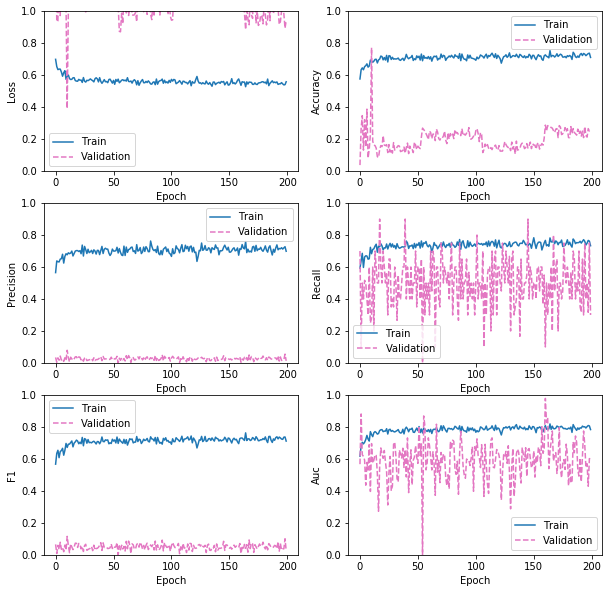

In [22]:
plt.figure(figsize=(10,10))
plot_metrics(up_history)

### Train with UP2 (1:10)

In [23]:
start = time.time()
up2_history = model.fit_generator(up2_train_generator, 
                              epochs=n_epochs, 
                              steps_per_epoch=n_steps_per_epoch,
                              validation_data=validation_generator,
                              validation_steps=n_validation_steps, 
                              callbacks=[reduce_lr]
                             )
end = time.time()

Epoch 1/200
50/50 [==============================] - 22s 438ms/step - loss: 0.6968 - Accuracy: 0.5788 - Precision: 0.1596 - Recall: 0.8438 - F1: 0.2608 - AUC: 0.7780 - val_loss: 1.2587 - val_Accuracy: 0.1125 - val_Precision: 0.0379 - val_Recall: 0.7000 - val_F1: 0.0712 - val_AUC: 0.5740
Epoch 2/200
50/50 [==============================] - 21s 422ms/step - loss: 0.6433 - Accuracy: 0.6425 - Precision: 0.2045 - Recall: 0.8054 - F1: 0.3133 - AUC: 0.7873 - val_loss: 1.2456 - val_Accuracy: 0.1250 - val_Precision: 0.0036 - val_Recall: 0.1000 - val_F1: 0.0069 - val_AUC: 0.3354
Epoch 3/200
50/50 [==============================] - 20s 399ms/step - loss: 0.6080 - Accuracy: 0.6612 - Precision: 0.2009 - Recall: 0.8070 - F1: 0.3077 - AUC: 0.8037 - val_loss: 1.1664 - val_Accuracy: 0.1437 - val_Precision: 0.0259 - val_Recall: 0.5000 - val_F1: 0.0484 - val_AUC: 0.7001
Epoch 4/200
50/50 [==============================] - 19s 390ms/step - loss: 0.5970 - Accuracy: 0.6662 - Precision: 0.1716 - Recall: 0.81

50/50 [==============================] - 18s 364ms/step - loss: 0.3352 - Accuracy: 0.8956 - Precision: 0.2433 - Recall: 0.2454 - F1: 0.2246 - AUC: 0.8042 - val_loss: 0.7896 - val_Accuracy: 0.2750 - val_Precision: 0.0134 - val_Recall: 0.2500 - val_F1: 0.0252 - val_AUC: 0.4225
Epoch 30/200
50/50 [==============================] - 19s 389ms/step - loss: 0.3432 - Accuracy: 0.8950 - Precision: 0.2710 - Recall: 0.2619 - F1: 0.2421 - AUC: 0.7684 - val_loss: 0.8591 - val_Accuracy: 0.3781 - val_Precision: 0.0270 - val_Recall: 0.3500 - val_F1: 0.0497 - val_AUC: 0.6757
Epoch 31/200
50/50 [==============================] - 18s 361ms/step - loss: 0.3372 - Accuracy: 0.8938 - Precision: 0.3617 - Recall: 0.2822 - F1: 0.2750 - AUC: 0.7981 - val_loss: 0.8385 - val_Accuracy: 0.3063 - val_Precision: 0.0229 - val_Recall: 0.5000 - val_F1: 0.0438 - val_AUC: 0.7009
Epoch 32/200
50/50 [==============================] - 19s 387ms/step - loss: 0.3389 - Accuracy: 0.8906 - Precision: 0.3283 - Recall: 0.2557 - F1: 

50/50 [==============================] - 19s 387ms/step - loss: 0.2860 - Accuracy: 0.9056 - Precision: 0.2267 - Recall: 0.0857 - F1: 0.1161 - AUC: 0.7944 - val_loss: 0.5098 - val_Accuracy: 0.6969 - val_Precision: 0.0363 - val_Recall: 0.2500 - val_F1: 0.0618 - val_AUC: 0.8121
Epoch 58/200
50/50 [==============================] - 18s 365ms/step - loss: 0.2799 - Accuracy: 0.9125 - Precision: 0.2600 - Recall: 0.1219 - F1: 0.1520 - AUC: 0.7930 - val_loss: 0.5897 - val_Accuracy: 0.6250 - val_Precision: 0.0329 - val_Recall: 0.3000 - val_F1: 0.0585 - val_AUC: 0.4723
Epoch 59/200
50/50 [==============================] - 19s 373ms/step - loss: 0.2649 - Accuracy: 0.9262 - Precision: 0.2000 - Recall: 0.1035 - F1: 0.1272 - AUC: 0.7717 - val_loss: 0.5569 - val_Accuracy: 0.7188 - val_Precision: 0.0322 - val_Recall: 0.2000 - val_F1: 0.0545 - val_AUC: 0.5404
Epoch 60/200
50/50 [==============================] - 19s 384ms/step - loss: 0.2841 - Accuracy: 0.9106 - Precision: 0.2400 - Recall: 0.0897 - F1: 

50/50 [==============================] - 19s 383ms/step - loss: 0.2400 - Accuracy: 0.9294 - Precision: 0.1100 - Recall: 0.0400 - F1: 0.0561 - AUC: 0.7840 - val_loss: 0.5285 - val_Accuracy: 0.8125 - val_Precision: 0.0736 - val_Recall: 0.1750 - val_F1: 0.1021 - val_AUC: 0.6250
Epoch 86/200
50/50 [==============================] - 19s 386ms/step - loss: 0.2456 - Accuracy: 0.9169 - Precision: 0.0600 - Recall: 0.0207 - F1: 0.0300 - AUC: 0.8135 - val_loss: 0.4603 - val_Accuracy: 0.8250 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.3660
Epoch 87/200
50/50 [==============================] - 20s 393ms/step - loss: 0.2603 - Accuracy: 0.9106 - Precision: 0.0400 - Recall: 0.0133 - F1: 0.0200 - AUC: 0.7928 - val_loss: 0.5179 - val_Accuracy: 0.8062 - val_Precision: 0.0811 - val_Recall: 0.2333 - val_F1: 0.1098 - val_AUC: 0.6408
Epoch 88/200
50/50 [==============================] - 19s 372ms/step - loss: 0.2332 - Accuracy: 0.9237 - Precision: 0.0800 - Recall: 0

Epoch 113/200
50/50 [==============================] - 19s 386ms/step - loss: 0.2675 - Accuracy: 0.9019 - Precision: 0.0400 - Recall: 0.0079 - F1: 0.0130 - AUC: 0.7957 - val_loss: 0.5141 - val_Accuracy: 0.8438 - val_Precision: 0.0375 - val_Recall: 0.1500 - val_F1: 0.0556 - val_AUC: 0.5573
Epoch 114/200
50/50 [==============================] - 19s 387ms/step - loss: 0.2476 - Accuracy: 0.9131 - Precision: 0.0600 - Recall: 0.0183 - F1: 0.0280 - AUC: 0.8079 - val_loss: 0.5331 - val_Accuracy: 0.8281 - val_Precision: 0.0200 - val_Recall: 0.1000 - val_F1: 0.0333 - val_AUC: 0.7170
Epoch 115/200
50/50 [==============================] - 20s 395ms/step - loss: 0.2424 - Accuracy: 0.9125 - Precision: 0.0800 - Recall: 0.0417 - F1: 0.0513 - AUC: 0.8293 - val_loss: 0.4258 - val_Accuracy: 0.7969 - val_Precision: 0.1030 - val_Recall: 0.4000 - val_F1: 0.1611 - val_AUC: 0.7202
Epoch 116/200
50/50 [==============================] - 20s 391ms/step - loss: 0.2765 - Accuracy: 0.8956 - Precision: 0.0500 - Reca

50/50 [==============================] - 19s 371ms/step - loss: 0.2608 - Accuracy: 0.9119 - Precision: 0.0600 - Recall: 0.0173 - F1: 0.0257 - AUC: 0.7729 - val_loss: 0.4165 - val_Accuracy: 0.8938 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.6824
Epoch 142/200
50/50 [==============================] - 19s 380ms/step - loss: 0.2422 - Accuracy: 0.9137 - Precision: 0.0600 - Recall: 0.0167 - F1: 0.0260 - AUC: 0.8172 - val_loss: 0.4030 - val_Accuracy: 0.8906 - val_Precision: 0.0167 - val_Recall: 0.1000 - val_F1: 0.0286 - val_AUC: 0.6383
Epoch 143/200
50/50 [==============================] - 20s 403ms/step - loss: 0.2575 - Accuracy: 0.9075 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - F1: 0.0000e+00 - AUC: 0.7949 - val_loss: 0.4336 - val_Accuracy: 0.8750 - val_Precision: 0.0533 - val_Recall: 0.1500 - val_F1: 0.0786 - val_AUC: 0.5496
Epoch 144/200
50/50 [==============================] - 19s 374ms/step - loss: 0.2631 - Accuracy: 0.9044 - Precision: 0.1

Epoch 169/200
50/50 [==============================] - 20s 394ms/step - loss: 0.2604 - Accuracy: 0.9087 - Precision: 0.0600 - Recall: 0.0150 - F1: 0.0237 - AUC: 0.7858 - val_loss: 0.3734 - val_Accuracy: 0.9312 - val_Precision: 0.0250 - val_Recall: 0.1000 - val_F1: 0.0400 - val_AUC: 0.5884
Epoch 170/200
50/50 [==============================] - 20s 392ms/step - loss: 0.2805 - Accuracy: 0.8994 - Precision: 0.0600 - Recall: 0.0132 - F1: 0.0211 - AUC: 0.7860 - val_loss: 0.3277 - val_Accuracy: 0.9125 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.6405
Epoch 171/200
50/50 [==============================] - 20s 398ms/step - loss: 0.2723 - Accuracy: 0.9013 - Precision: 0.1000 - Recall: 0.0319 - F1: 0.0463 - AUC: 0.7963 - val_loss: 0.3164 - val_Accuracy: 0.9187 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.4989
Epoch 172/200
50/50 [==============================] - 20s 392ms/step - loss: 0.2675 - Accuracy: 0.9081 - 

50/50 [==============================] - 20s 395ms/step - loss: 0.2500 - Accuracy: 0.9100 - Precision: 0.0400 - Recall: 0.0167 - F1: 0.0233 - AUC: 0.8307 - val_loss: 0.3441 - val_Accuracy: 0.9406 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.5216
Epoch 197/200
50/50 [==============================] - 20s 410ms/step - loss: 0.2469 - Accuracy: 0.9169 - Precision: 0.0800 - Recall: 0.0300 - F1: 0.0427 - AUC: 0.7954 - val_loss: 0.3684 - val_Accuracy: 0.9438 - val_Precision: 0.0333 - val_Recall: 0.1000 - val_F1: 0.0500 - val_AUC: 0.6130
Epoch 198/200
50/50 [==============================] - 20s 405ms/step - loss: 0.2385 - Accuracy: 0.9156 - Precision: 0.1000 - Recall: 0.0350 - F1: 0.0507 - AUC: 0.8292 - val_loss: 0.4156 - val_Accuracy: 0.9375 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.4247
Epoch 199/200
50/50 [==============================] - 20s 401ms/step - loss: 0.2467 - Accuracy: 0.9125 - Precision: 0.1

In [24]:
print("Time taken:",end-start)

Time taken: 3882.914446115494


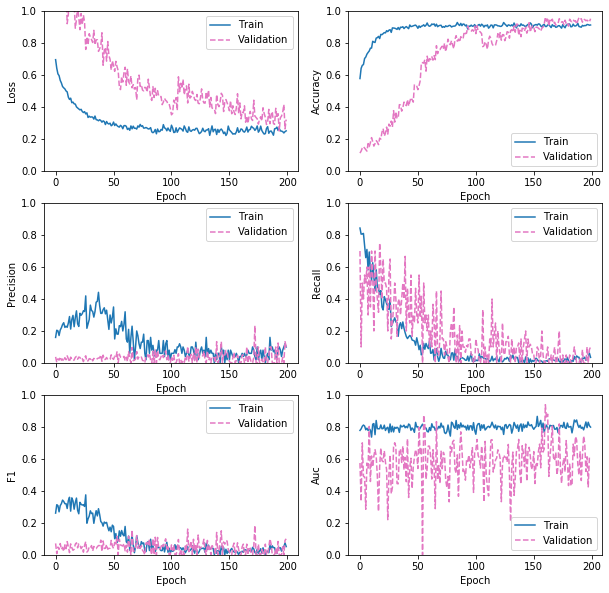

In [25]:
plt.figure(figsize=(10,10))
plot_metrics(up2_history)

### Train with UP3 (1:20)

In [26]:
# start = time.time()
# up3_history = model.fit_generator(up3_train_generator, 
#                               epochs=n_epochs, 
#                               steps_per_epoch=n_steps_per_epoch,
#                               validation_data=validation_generator,
#                               validation_steps=n_validation_steps,
#                               class_weight = [0.5, 1],
#                               callbacks=[reduce_lr]
#                              )
# end = time.time()

In [27]:
# print("Time taken:",end-start)

In [28]:
# plt.figure(figsize=(10,10))
# plot_metrics(up3_history)

### Train with Imbalanced original train data (1:40)

In [29]:
# start = time.time()
# imb_history = model.fit_generator(imb_train_generator,
#                                   epochs=n_epochs,
#                                   steps_per_epoch=n_steps_per_epoch,
#                                   validation_data=validation_generator,
#                                   validation_steps=n_validation_steps,
#                                   class_weight = [0.5, 2],
#                                   callbacks=[reduce_lr]
#                                  )
# end = time.time()

In [30]:
# print("Time taken:",end-start)

In [31]:
# plt.figure(figsize=(10,10))
# plot_metrics(imb_history)

## Evaluation

In [32]:
results_tr = model.evaluate(imb_train_generator,steps=100)
results_vl = model.evaluate(validation_generator,steps=100)

100/100 [==============================] - 17s 175ms/step


In [33]:
print("NAME :\tTRAIN :\tVALIDATION ")
for name, value_tr, value_vl in zip(model.metrics_names, results_tr, results_vl):
    print("%s : %5.3f : %7.3f" %(name, value_tr , value_vl))

# without classweights:
# NAME :	TRAIN :	VALIDATION 
# loss : 0.754 :   0.465
# Accuracy : 0.531 :   0.866
# Precision : 0.006 :   0.006
# Recall : 0.070 :   0.040
# F1 : 0.011 :   0.010
# AUC : 0.565 :   0.544

NAME :	TRAIN :	VALIDATION 
loss : 0.519 :   0.504
Accuracy : 0.758 :   0.905
Precision : 0.019 :   0.033
Recall : 0.117 :   0.055
F1 : 0.031 :   0.037
AUC : 0.502 :   0.561


## Prediction
The output of a binary classification is the probability of a sample belonging to a class.

In [34]:
# PREDICTED LABELS
start = time.time()
pred_tr = model.predict(imb_train_generator)
tr_end = time.time()
pred_vl = model.predict(validation_generator)
vl_end = time.time()

tr_end-start , vl_end-tr_end

(796.5060024261475, 152.35750222206116)

In [35]:
# np.save(funduspath_CR + str(n_epochs) + 'ep_traintwice_newtr.npy', pred_tr)
# np.save(funduspath_CR + str(n_epochs) + 'ep_traintwice_newvl.npy', pred_vl)

In [36]:
# val_class = []
# for i, predicted in enumerate(pred_vl):
#     if predicted[0] > 0.1:
#         #assign i to class 1
#         val_class.append(1)
#     else:
#         #assign i to class 0
#         val_class.append(0)

In [37]:
# TRUE LABELS

train_labels = valid_traindf_names[Class].tolist()
train_labels = [int(i) for i in train_labels]

val_labels = valid_valdf_names[Class].tolist()
val_labels = [int(i) for i in val_labels]


### ROC Curve

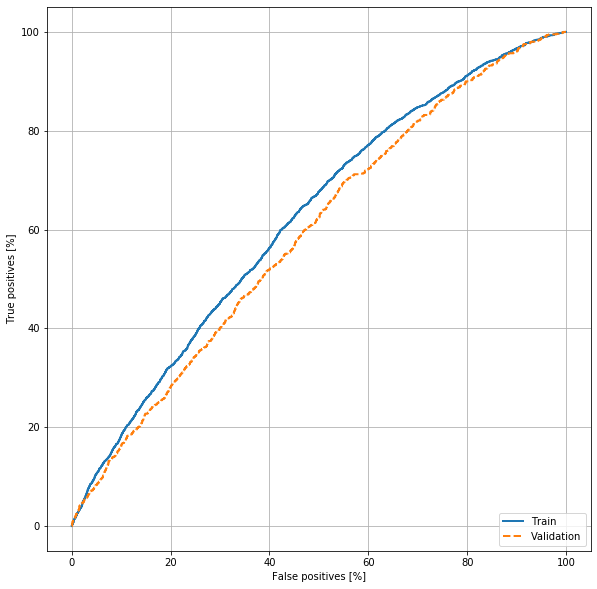

In [38]:
plt.figure(figsize=(10,10))
plot_roc("Train", train_labels, pred_tr, color=colors[0])
plot_roc("Validation", val_labels, pred_vl, color=colors[1],linestyle='--')
# plot_roc("Validation", val_labels, val_class, color=colors[3],linestyle='-.') # theshold 0.1
plt.legend(loc='lower right')

### Confusion matrix

Train data: 
TN: 79475 
FP: 19980 
FN: 1607 
TP: 772
Healthy Patients - correctly identified (True Negatives):  79475 0.7991051229199135
Healthy Patients - predicted to have glaucoma (False Positives):  19980 0.20089487708008646
Glaucoma Patients - predicted healthy (False Negatives):  1607 0.6754939050021017
Glaucoma Patients - correctly identified (True Positives):  772 0.3245060949978983

Total Glaucoma patients:  2379 1.0
Total Healthy patients:  99455 1.0


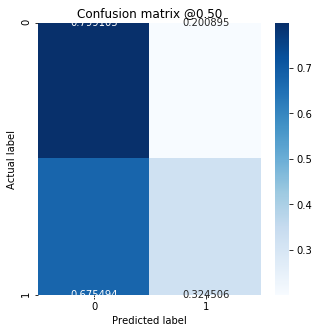

In [39]:
tn, fp, fn, tp = confusion_matrix(train_labels, pred_tr > 0.5).ravel()
train_cm = [tn, fp, fn, tp]
print("Train data: \nTN:",tn,"\nFP:",fp,"\nFN:",fn,"\nTP:",tp)
plot_cm(train_labels, pred_tr)

Validation data: 
TN: 31211 
FP: 1923 
FN: 733 
TP: 76
Healthy Patients - correctly identified (True Negatives):  31211 0.9419629383714614
Healthy Patients - predicted to have glaucoma (False Positives):  1923 0.05803706162853866
Glaucoma Patients - predicted healthy (False Negatives):  733 0.9060568603213844
Glaucoma Patients - correctly identified (True Positives):  76 0.09394313967861558

Total Glaucoma patients:  809 1.0
Total Healthy patients:  33134 1.0


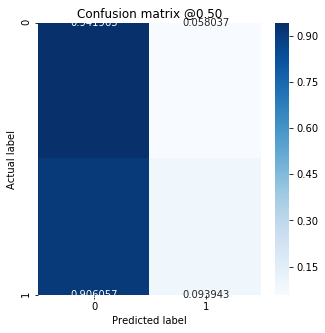

In [40]:
tn, fp, fn, tp = confusion_matrix(val_labels, pred_vl > 0.5).ravel()
val_cm = [tn, fp, fn, tp]
print("Validation data: \nTN:",tn,"\nFP:",fp,"\nFN:",fn,"\nTP:",tp)
plot_cm(val_labels, pred_vl)

### MLFlow 

In [41]:
# history = up2_history
# tag_value = "trained twice bal and 1:10 with 78 tr layers"

# exp_name = get_notebook_name()+"-run at-"+datetime.datetime.now().strftime("%d%b%Y %H:%M")
# keras_model_path = funduspath_CR+ exp_name + '_model'
# save_mlflow(keras_model_path,exp_name,which_gt,which_model,seq,BATCH_SIZE,
#             n_epochs,n_steps_per_epoch,n_validation_steps,
#             reg_value,learning_rate,decay,opt,
#             history,results_tr,results_vl,train_cm,val_cm
#            )

In [42]:
# client = MlflowClient()
# run = client.create_run('16')
# client.set_tag(run.info.run_id, "tag_key", tag_value)